# Utilities

In [25]:
%gui wx
import os
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, DownloadProgressBar, download_url, direct_file_download_open_neuro, get_json_from_file
os.environ["DIPY_HOME"] = "./data/"
loadFSL()
import fsl.wrappers
from fsl.wrappers import fslmaths, mcflirt
import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri
import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob
import ants
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report
import requests
import urllib.request
from tqdm import tqdm
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt
import glob
import pandas as pd
import numpy as np
import json
import subprocess
import matplotlib.pyplot as plt

In [29]:
%load_ext autoreload
%autoreload 2
from utilities import get_skull_stripped_anatomical, apply_python_mask_approach, launch_freeview, fsl_anat_wrapped, load_mot_params_fsl_6_dof, compute_FD_power

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%%capture
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

# Folders

In [ ]:
dataset_id = 'ds000171' 
subject_id = 'control01'    
sample_path = "./data/" 
os.makedirs(sample_path, exist_ok=True)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives') 
preproc_root = op.join(bids_root, 'derivatives', 'preprocessed_data') 
os.makedirs(bids_root, exist_ok=True)
subject_dir = 'sub-{}'.format(subject_id)

## Download

In [ ]:
subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, 
                "--target-dir", bids_root, 
                "--include", op.join(subject_dir, '*'),    
               ], check=True) 
os.makedirs(op.join(bids_root, 'derivatives'), exist_ok=True)
preproc_root = op.join(bids_root, 'derivatives', 'preprocessed_data') 
os.makedirs(op.join(preproc_root, subject_dir), exist_ok=True)
os.makedirs(op.join(preproc_root, subject_dir, 'anat'), exist_ok=True)
os.makedirs(op.join(preproc_root, subject_dir, 'func'), exist_ok=True)
os.makedirs(op.join(preproc_root, subject_dir, 'fmap'), exist_ok=True)

In [ ]:
%%capture
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')) 

# Skull stripping

###  Preprocessing and BIDs
An important part of **anatomical** preprocessing is to remove the skull around the brain.
To adhere to the BIDs format, all modified files should be put in a new folder, called derivatives, such that you always have clean data in the source directory. The derivatives folder can be used for different preprocessing and treatments, each needing their own subfolders. In our case, we've created a single folder, preprocessed_data, hence the following structure:

In [ ]:
resulting_mask_path = op.join(preproc_root, subject_dir, 'anat', 'sub-{}_T1w_mask'.format(subject_id) ) 
get_skull_stripped_anatomical(bids_root, preproc_root, "control01") 

In [ ]:
fsleyesDisplay.load(resulting_mask_path)

### Improving the fit
If you look a bit into bet's documentation, you'll quickly find that there are parameters with which you can play; robust brain centre estimation and fractional intensity threshold. To demonstrate the importance and impact of these parameters, let's use a robust brain center estimation.

In [ ]:
get_skull_stripped_anatomical(bids_root, preproc_root, "control01", robust=True)

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))
fsleyesDisplay.load(resulting_mask_path)

### 1.1.4 Manual corrections
If you really want good fit, you might want to resort to **manually correcting the mask**. Run the code above to check whether the result is satisfactory or not. 

FSLeyes readily allows you to do such things! While on FSLeyes, press **Alt + E** to open the editing interface.

>Edit


You can then escape back to the non-edit mode by pressing again **Alt + E**


In [6]:
anatomical_path = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')
betted_brain_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz') 
resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask.nii.gz') 
apply_python_mask_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

## 1.2 Tissue segmentation

For the purpose of analysis, it can be useful to separate the tissues into tissue classes; in particular extracting the white matter, grey matter and cerebrospinal fluid (abreviated as CSF) is very interesting in fMRI analysis

It is perfectly possible (even likely) that FSLeyes will stop responding over the course of this lab. This is perfectly normal! Simply wait for whichever function (such as FAST) to finish and it should start responding again, don't worry too quickly, be patient :)</p>


Note that FAST will take one or two minutes to run, this is expected, do not panic :)

In [8]:
betted_brain_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w')
fast_target = betted_brain_path 

In [ ]:

[os.remove(f) for f in glob.glob(op.join(preproc_root, 'sub-control01', 'anat', '*fast*'))]
segmentation_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

Let's check the quality of the segmentation, shall we?
We want to extract 3 tissue types here: the white matter, the grey matter and the csf. How well did fast perform?

In [ ]:
print_dir_tree(bids_root, max_depth=5)

The pve files correspond to our segmented tissues. We have exactly three files, because we set n_classes to 3 above:
```python
fast(..., n_classes=3)


To make it easier on you, we will display:

- pve_0 in <span style="color:red;">red</span>
- pve_1 in <span style="color:green;">green</span>
- pve_2 in <span style="color:blue;">blue</span>

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)
# CSF
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_0*'))[0])
# GM
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_1*'))[0])
# WM
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_2*'))[0])

fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'


# Coregistration of images, a critical preprocessing step

In principle, it could be done manually

In [ ]:
import threading


# List of images to load in Freeview. 
# img_list contains paths to neuroimaging files you want to visualize:
# A standard anatomical template (MNI152) for reference.
# A subject-specific anatomical image with a specific colormap (greyscale).
imgList = [
    op.expandvars('$FSLDIR/data/standard/MNI152_T1_1mm.nii.gz'), # Path to the standard MNI template image
    op.join(preproc_root, "sub-control01", "anat", "sub-control01_T1w.nii.gz:colormap=greyscale") # Path to the subject's anatomical image with colormap set to greyscale
    # You can modify this list to add any other images you want to view in .nii.gz format
]

# Create a new thread to run Freeview with the list of images
# We pass the target function (launch_freeview) and the arguments (imgList,)
# The comma is necessary to pass a tuple to 'args' so threading works correctly
freeview_thread = threading.Thread(target=launch_freeview, args=(imgList,))

# Start the thread to launch Freeview in the background
freeview_thread.start()

# Print a message indicating that Freeview is running in a separate thread
print("Freeview is running in a separate thread.")


Wait, we can't see anything apart from the top brain. No worries! Simply set the background to be transparent by ticking the Clear Background option, as in the picture below:


### Manual approach

Let's start with a straightforward approach: you will align the images manually. In Freeview, click in Tools > Transform Volume.
You should get the following panel:

Now, play with the sliders of translation and rotation to align the anatomical to the reference. </b> Try to align the two brains as best you can.</p>


The MRI and the template are not very well aligned, but we can try to make them more aligned. Specifically, we would like to find a transformation such that we can align our anatomical to the MNI template. This is the so-called normalization step.

### Types of normalization

So, you now know that you need a transformation and a reference. Great. Now, the transformation you allow can be of two types: it can be linear, meaning whatever you apply will be the same across the entire image, or non linear, where each voxel gets a separate treatment

(ducky linear and non linear)



## Actually doing it: Linear normalization

To perform linear normalization, the idea is simple. The transformation we want should be linear - ie, affine.
Such a matching is usually called in image processing **image registration**. Here, we're dealing with 3D data, so the problem is a bit more complicated. Fortunately all of this has been coded by very smart people, and to our rescue comes a tool specifically to register volumes to each other.

This tool can allow many registrations and is extremely powerful. In its most basic form, it expects:
- An input volume, the volume you want to register (Ducky's sunglasses)
- A reference volume, to which the input is registered (Ducky's body)
- An output volume, the result of the transformation (Ducky's sunglasses once they are on Ducky's beak)

Here is how you can call it to register the patient's anatomical to some reference sitting in another space (here the MNI152 template):
```python
flirt()
```
💡 Pay attention! 💡
    FLIRT expects the anatomical to be skull stripped to maximize normalization. Luckily, you already did it before with BET.</p>


In [ ]:

subject_id = 'control01' 
subject_anatomical = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-control01_T1w')
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))

target = subject_anatomical 
reference = mni_template 
result = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni'.format(subject_id))
flirt(target, reference, out=result)

Visualize the result of flirt on top of the reference. What do you think of alignment?

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(reference) 
fsleyesDisplay.load(result)

Which cost should we use? If you were in a pure void, there would be no right or wrong answer from the get-go. No choice but to experiment and find out!

Hopefully, <a href="https://fsl.fmrib.ox.ac.uk/fsl/docs/#/registration/flirt/user_guide?id=flirt">the documentation</a> should give you some pointers. What you want here is to register a T1 to a T1: this is a <u>within</u> modality registration, so you should restrict yourself only to costs appropriate to this type of modality! 

To help you, we've set up a cell that will run the different coregistrations for you. Simply fill in the different costs to consider :)

In [ ]:
possible_costs = ['mutualinfo', 'corratio', 'normcorr', 'normmi', 'leastsq', 'labeldiff']
# Define a list of all possible cost functions supported by FLIRT. These include:
# - 'mutualinfo': Mutual information (cross-modalities).
# - 'corratio': Correlation ratio (can work across or within modalities).
# - 'normcorr': Normalized correlation (within-modalities).
# - 'normmi': Normalized mutual information (cross-modalities).
# - 'leastsq': Least squares (within-modalities).
# - 'labeldiff': Label difference (special cases, such as segmentation images).

costs_to_consider = ['leastsq', 'normcorr'] 
# Select the relevant cost functions for within-modalities (T1-to-T1 alignment):
# - 'leastsq': Uses least squares, suitable for aligning images of the same modality.
# - 'normcorr': Uses normalized correlation, also suitable for within-modality alignment.
# FIXME: ISSUE WITH THE LEASTSQ COST RESULT
for c in costs_to_consider:
    flirt(target, reference, out=result + '_' + c, cost=c)

In [ ]:
for c in costs_to_consider:
    fsleyesDisplay.load(result + '_' + c)

## Non linear normalization

So, you know how to do it linearly.  What if we wanted to do it non-linearly?

With FLIRT, <i>it's painfully hard</i>. To do it, you can use *FNIRT*. 

But, there are other tools available, one of them being <a href="https://github.com/ANTsX/ANTs">ANTs (Advanced Normalization Tools)</a>.
For completeness, we will show you now how to use it (very succinctly) so that you know how to do it.


💡 Pay attention! 💡

FNIRT does NOT expect the input data to be skull-stripped.</p>

In [16]:
moving_image = ants.image_read(target + '.nii.gz')
fixed_image = ants.image_read(reference + '.nii.gz')
transformation = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform='SyN')
warpedImage = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=transformation['fwdtransforms'])
resultAnts = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni_SyN.nii.gz'.format(subject_id))
ants.image_write(warpedImage, resultAnts)

Look at the results and compare it against the linear coregistration. Which one do you prefer? Why?

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(reference)
fsleyesDisplay.load(result)
fsleyesDisplay.load(resultAnts)


As a final note, all these steps (<u>including</u> non linear normalization!) can be done automatically for you with a single command: <a href="https://web.mit.edu/fsl_v5.0.10/fsl/doc/wiki/fsl_anat.html">fsl_anat</a>. So you might want to use this command, instead of running all of the above when conducting preprocessing.

We provide it here for convenience, but beware: it takes <b>several minutes</b> to complete, so you will need some patience!


In [ ]:
fsl_anat_wrapped(anatomical_path, op.join(preproc_root, 'sub-001', 'anat'))

<div class="warning" style='background-color:#C1ECFA; color: #112A46; border-left: solid darkblue 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'><b> 💡 Careful ! 💡</b></p>
<p style='text-indent: 10px;'>
    Some of the fMRI preprocessing you will see below leverage the anatomical MRI being preprocessed.
</div>

# fMRI preprocessing

Note that one assumption with fMRI preprocessing is that you've already conducted the anatomical preprocessing. In particular, the two main steps you will need today (repeat it from lab 2) before launching the lab:
- T1 skull-stripping (use BET)
- T1 segmentation (use FAST)

## Problematic volumes removal

To open one particular volume, run the cell below:

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_bold.nii.gz'))

### Field stabilization

The scanner's field takes some time to settle. You probably noticed that the initial volume had a high contrast that quickly decayed to some baseline? It is precisely caused by the scanner's field settling.

These scans are called *non-stationary volumes*, because they are acquired while the B0 field is not yet not stable.

There's little to be done in this regard; we can only throw away the volumes that are contaminated in this specific case, to ensure this change in global signal does not drive our analysis.

If we're being really formal, a higher overall contrast can be detected by looking at the mean voxel value in each volume, like so:

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib

plt.plot(nib.load(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_bold.nii.gz')).get_fdata().mean(axis=(0,1,2)))
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

We'll **choose** to discard the first 10 volumes

Most scanners nowadays actually acquire few scans to help the B0 field settle. These are called dummy scans; the scanner acquires them but throws them away, meaning that you end up with a result that is settled. You should pay attention however if you ever analyze older datasets, as they will not benefit from these new techs obviously!

In [ ]:
### This script considers a test file reported in a lab, feel free to modify it ! ###

# file_to_trim = glob.glob(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_bold.nii.gz'))[0]
# Search for the functional MRI (fMRI) file matching the specified pattern using glob.
# The file path is constructed to locate the BOLD image for subject 'sub-01' in the 'ses-test' session under the 'func' directory.
# The '[0]' at the end retrieves the first match found.

# mkdir_no_exist(preproc_root)
# Create the root directory for preprocessed data if it doesn't already exist. This will be used to store the output files.

# mkdir_no_exist(op.join(preproc_root, 'sub-control01'))
# Create a directory for subject 'sub-control01' under the preprocessed data directory if it doesn't exist.

# mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'ses-test'))
# Create a directory for the session 'ses-test' within the subject's directory under the preprocessed data directory.

# mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'ses-test','func'))
# Create the 'func' directory within the session folder. This directory will hold the functional data after processing.

# output_target = op.join(preproc_root, 'sub-control01', 'ses-test', 'func', 'sub-01_ses-test_task-fingerfootlips_bold_settled.nii.gz')
# Define the output path for the trimmed fMRI data. 
# The path includes the subject ID, session ID, and specifies the name for the new file ('sub-01_ses-test_task-fingerfootlips_bold_settled.nii.gz').

############################
# Solution
# We will start from the 10th volume.
# Because indexing starts at 0, the 11th volume corresponds to index 10, so we exclude the first 10 volumes.
# The original dataset has 184 volumes. By excluding the first 10, we retain 174 volumes.
###########################

# Define the variables for the starting volume and the number of volumes to keep
# start_vol = 10 # The volume index to start from (0-based indexing, so this is the 11th volume).
# number_of_volumes = 174 # The number of volumes to keep after trimming, leaving 174 volumes from the original 184.

# fslroi(file_to_trim, output_target, str(start_vol), str(number_of_volumes))
# Run the 'fslroi' command to extract a subset of volumes from the original fMRI file.
# - 'file_to_trim': The path to the original fMRI file.
# - 'output_target': The path where the trimmed file will be saved.
# - 'start_vol': The starting volume (10) to begin extracting.
# - 'number_of_volumes': The number of volumes (174) to extract, starting from 'start_vol'.


## Motion correction

In FSL, we use <a href="https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/MCFLIRT">MCFLIRT</a> to perform this correction.

By default, MCFLIRT selects the middle volume of the EPI serie as reference to which other volumes are realigned.</p>


In [19]:
path_original_data = os.path.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold')
path_moco_data = os.path.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco')

mcflirt(
    infile=path_original_data,  # The input file (original BOLD data)
    o=path_moco_data,           # The output file (motion-corrected data)
    plots=True,                 # Generate plots for visualizing motion correction.
    report=True,                # Generate a report on the motion correction process.
    dof=6,                      # Set degrees of freedom to 6 for rigid-body transformation.
    mats=True                   # Save the transformation matrices.
)

Processed data will be saved as ./data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling
Rescaling reference volume [52] to 4 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


{}

In the functional folder, notice that we have two new files:
```
sub-control01_task-music_run-1_bold_moco.nii.gz
sub-control01_task-sitrep_run-1_bold_moco.par

```

The first one is the corrected EPI time serie, with volumes realigned. The second is a file describing the motion parameters that were used to move each volume. It will be useful very shortly to determine which volume moved by a lot.
Notice as well a new directory!
```
sub-control01_task-sitrep_run-1_bold_moco.mat/
```
This directory is full of .MAT files. These are the transformation matrices used for every volume to realign them.

In [20]:
fsleyesDisplay.resetOverlays() # Reset the overlays in FSLeyes
fsleyesDisplay.load(path_original_data) # Load the original data in FSLeyes
fsleyesDisplay.load(path_moco_data) # Load the motion corrected data in FSLeyes


(ipykernel_launcher.py:349177): Gtk-CRITICAL **: 23:01:59.671: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:349177): Gtk-CRITICAL **: 23:01:59.694: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:349177): Gtk-CRITICAL **: 23:01:59.751: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:349177): Gtk-CRITICAL **: 23:01:59.770: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:349177): Gtk-CRITICAL **: 23:01:59.867: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:349177): Gtk-CRITICAL **: 23:01:59.888: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:349177): Gtk-CRITICAL **: 23:01:59.944: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)'


(ipykernel_launcher.py:349177): Gtk-WARNING **: 23:02:01.618: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:349177): Gtk-WARNING **: 23:02:01.618: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:349177): Gtk-WARNING **: 23:02:01.618: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:349177): Gtk-WARNING **: 23:02:01.618: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:349177): Gtk-CRITICAL **: 23:02:05.328: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:349177): Gtk-CRITICAL **: 23:02:05.348: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed


The motion parameters are stored in the .par file produced by MCFLIRT. Notice that since each volume moved differently, we have one transformation per volume, thus one set of motion parameters per volume as well. We provide you with a way to load these parameters:

In [23]:
mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco.par')) 
mot_params # It returns a dataframe with the motion parameters 

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.000843,0.000589,-0.000283,-0.020640,-0.088168,-0.061575
1,0.000587,0.000481,-0.000326,-0.020651,-0.071060,-0.046486
2,0.000933,0.000589,-0.000394,-0.020618,-0.046722,-0.035206
3,0.000550,0.000816,-0.000394,-0.020571,-0.072742,-0.049830
4,0.000858,0.000589,-0.000394,-0.020618,-0.060591,-0.083145
...,...,...,...,...,...,...
100,0.000952,-0.000853,0.000040,-0.013383,0.118385,0.187859
101,0.000457,-0.001224,0.000051,-0.009799,0.133098,0.214907
102,0.001244,-0.001305,0.000298,-0.028813,0.134919,0.187284
103,0.000731,-0.001537,0.000073,-0.030532,0.127386,0.185354


Based on **translation on X alone**, can you find perhaps a volume which exceeds with respect to the **preceding volume** a 0.2 mm displacement?

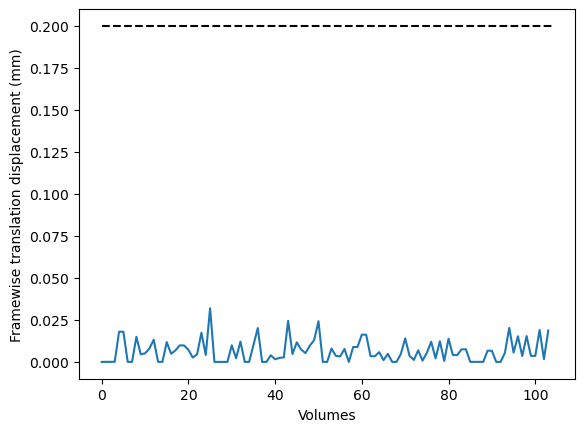

In [28]:
trans_x = mot_params["Translation x"] # Getting the translation on X
# Now, we want a 0.2mm with respect to previous frame:
disp_x = np.diff(trans_x) # Getting the displacement on X. We use np.diff to calculate the difference between consecutive elements in the translation on X.
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2 
plt.plot(np.abs(disp_x))
plt.hlines(threshold, 0, len(disp_x),colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

Now, we can use the code below to extract an aggregate measure of motion for all volumes. 

In [30]:
fd = compute_FD_power(mot_params).to_numpy()

In [31]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

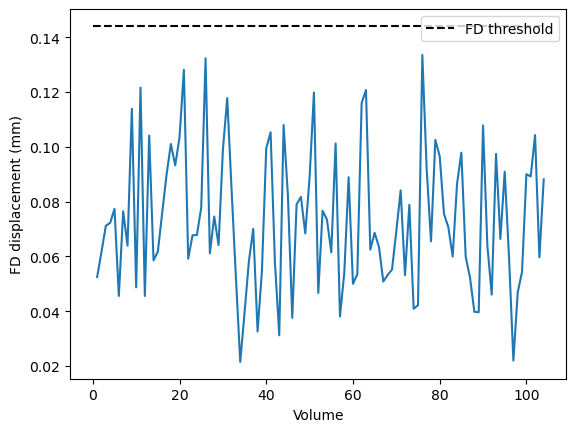

In [33]:
#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, len(fd),colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

Okay great, but what if we want to know which volumes are actually above threshold? Simply run the cell below!

In [34]:
np.where(fd > threshold)[0] + 1 

array([], dtype=int64)

## Motion-correction: conclusions

Motion correction should always be conducted. As you've seen, it is extremely easy to do and has many benefits. However it is not infaillible. High motion tends to cause non linear effects in the signal that simple motion correction above cannot correct since it has no awareness of the magnetic field. <br>
<br> Motion parameters can, in this case, come to our rescue. As they represent the effect of motion, including them in our modeling to try and correct the signal can help. One could for example include this information in a General Linear Model to regress out the signal of these volumes (censoring) from overall timeseries. ➡️ More on this next week!

## Where are we?

So, let's see what we have done so far:

<table>
    <tr><th style='text-align:justify;'>Data type</th><th style='text-align:justify;'>Step name </th><th style='text-align:justify;'>Details of the step</th><th style='text-align:justify;'>FSL tool </th></tr>
    <tr><th>Anatomical</th><td></td><td></td></tr>
    <tr><td></td><td style='text-align:justify;'>Skull stripping</td><td style='text-align:justify;'>Removing skull and surrounding tissues to keep only the brain</td><td style='text-align:justify;'>BET</td></tr>
    <tr><td></td><td style='text-align:justify;'>Segmentation</td><td style='text-align:justify;'>Segmenting brain tissues based on their contrasts</td><td style='text-align:justify;'>FAST</td></tr>
    <tr><td></td><td style='text-align:justify;'>Normalization</td><td style='text-align:justify;'>Mapping participant's brain to a reference brain, making its orientation and scale match so that comparison across participants become feasible.</td><td style='text-align:justify;'>FLIRT</td></tr>
    <tr><th>Functional</th><th></th><th></th></tr>
    <tr><td></td><td style='text-align:left;'>First few volumes removal</td><td style='text-align:justify;'>Removing volumes for which the B0 field is still not stable and that could contaminate all our data if left unchecked.</td><td style='text-align:justify;'>fslroi</td></tr>
    <tr><td></td><td style='text-align:left;'>Motion correction</td><td style='text-align:justify;'>Realignment of fMRI volumes to a common reference - typically one volume or the average of the volumes - to correct for inter-volume motion. The extracted motion parameters can be used for subsequent analysis (see GLM in two weeks!)</td><td style='text-align:justify;'>MCFLIRT (which is one suboption of FLIRT in fact)</td></tr>
</table>



## Coregistration of functional to anatomical

You have seen coregistration last week, when you were trying to align the T1 to MNI152, both manually and algorithmically. In the specific case of putting a T1 anatomical in a template space (such as MNI), we call it <b>normalization</b>, because we...Normalize it !

You've also seen above with motion-correction coregistration of EPI volumes (functional data) to each other to correct motion.

But what if you wanted to put the functional data overlayed on the anatomy, to know more precisely which parts of the brain are activated? (**coregistration between functional and anatomical**)

Computing the fMRI space to anatomical transformation is precisely the goal of coregistration.
<br><br>
To do this step, we will use : <a href="https://web.mit.edu/fsl_v5.0.10/fsl/doc/wiki/FLIRT(2f)UserGuide.html#epi_reg">epi_reg</a> ! 

### Using epi_reg to do the EPI registration



<div class="warning" style='background-color:#C1ECFA; color: #112A46; border-left: solid darkblue 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'><b> 💡 Pay attention ! 💡</b></p>
<p style='text-indent: 10px;'>
    Make sure that the whole head T1 and the skull-stripped T1 have the same orientation.
For example, if you ran fsl_anat to extract the brain (which is fine), FSL will change in the headers the orientation of the T1 before skull-stripping. As a consequence, the brain-extracted T1 no longer has the same orientation as the original T1. If you display them on top of each other, they are perfectly matched, but not from the perspective of the <b>headers</b>, which can play nasty tricks on you when performing coregistration.</p>
</span>
</div>

Note that if parallel acceleration is used in the EPI acquisition then the *effective echo spacing* is the actual echo spacing between acquired lines in k-space divided by the acceleration factor.

epi_reg has one peculiarity. If you launch it on a 4D volume, it will truncate your result to the first volume, because it expects a *single* EPI volume. We should thus first extract a single volume from our EPI, and then call epi_reg on it. We do that for you below.

If you want to run with 4D volume to see the result and the warning, set use_single_vol to False

In [ ]:
from fsl.wrappers import epi_reg

#################
# Solution
# We use the motion-corrected EPI
##################

# Define the path to the motion-corrected EPI (functional) image.
epi_target = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco') # To change 

# Define the path to the whole (unprocessed) T1-weighted anatomical image.
whole_t1 = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w')

# Define the path to the skull-stripped T1-weighted anatomical image.
skull_stripped_t1 = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w') # ...

# Define the path where the output of the epi_reg process will be saved.
output_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_bbr') # ....

# Define the path for the middle volume of the motion-corrected EPI file, which will be extracted as a reference.
ref_vol_name = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco_vol_middle') 

# Set whether to use a single volume as a reference. This can be useful for registration purposes.
use_single_vol = True

if use_single_vol:
    # Extract the middle volume of the EPI image using fslroi. This extracts a single volume from the time series.
    # '182' is the index of the middle volume (assuming the total number of volumes is known). # To change 
    # '1' indicates that only one volume will be extracted.
    fslroi(epi_target, ref_vol_name, str(), str(1))
    
    # Run epi_reg to register the extracted middle EPI volume to the T1-weighted anatomical image.
    subprocess.run([
        'epi_reg',
        '--epi={}'.format(ref_vol_name),  # The EPI image (middle volume) to be registered.
        '--t1={}'.format(whole_t1),       # The whole, non-skull-stripped T1-weighted image.
        '--t1brain={}'.format(skull_stripped_t1),  # The skull-stripped T1-weighted image.
        '--out={}'.format(output_path)    # The output path where the registered image will be saved.
    ])
else:
    # If not using a single volume, register the entire motion-corrected EPI series to the T1-weighted anatomical image.
    subprocess.run([
        'epi_reg',
        '--epi={}'.format(epi_target),    # The full motion-corrected EPI image (all volumes).
        '--t1={}'.format(whole_t1),       # The whole, non-skull-stripped T1-weighted image.
        '--t1brain={}'.format(skull_stripped_t1),  # The skull-stripped T1-weighted image.
        '--out={}'.format(output_path)    # The output path where the registered image will be saved.
    ])


Notice how FAST is ran?
This is because the specific coregistration cost (boundary-based registration, BBR) uses the **anatomical white-matter tissues from FAST**. If no such tissue is provided to the function, it re-runs FAST to obtain it and use it. If you've already done anatomical segmentation. 

If you had to yourself correct the white matter with the help of an expert because somehow FSL did a poor job on your data. Clearly you'd like to have this one used instead of the result from FAST, right?

Well- you can! We just need a new option in the epi_reg command:
```python
epi_reg(...,wmseg=path_to_your_white_matter_segmentation)
```
Remember from last week, which T1 file corresponds to the white matter, between pve_0, pve_1 and pve_2 ? 

In [ ]:
###############
# Solution
# White matter corresponds to pve_2.
##############

white_matter_segmentation = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_fast_pve_2.nii.gz') # We provide the white matter segmentation

subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(output_path),
               '--wmseg={}'.format(white_matter_segmentation)])

Let's overlay the two (EPI and anatomical) on top of each other to visualize the quality of the coregistration!

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(skull_stripped_t1)
fsleyesDisplay.load(output_path)


- Is the functional in the right orientation?
- Are the ventricles correctly aligned?
- Are the boundaries of the EPI more or less matching the anatomical?

➡️ You can also check how the white matter of the EPI matches your anatomical's white matter provided you have sufficient resolution

#### Some cleanup
If you have a look, you might notice that perhaps your directory got filled with many files. These are temporary files, created but uncorrectly not eliminated by epi_reg. The following should help:


In [ ]:
def cleanup_epi_reg(path_to_clean):
    patterns = ['*_fast_*', '*_fieldmap*']
    for p in patterns:
        files = glob.glob(op.join(path_to_clean, p))
        for f in files:
            os.remove(f)

In [ ]:
cleanup_epi_reg(op.join(preproc_root, 'sub-control01', 'func'))

In [ ]:
print_dir_tree(bids_root, max_depth=5)

#### Smoothing

All these transforms are not exactly perfect. As you've seen in class, a step of smoothing is typically applied, with the size of the smoothing being dependent on your application, starting resolution etc.
The idea of smoothing is really that, as you're averaging, hopefully you increase the signal to noise ratio. <br>
A side-effect is that finest patterns of activation will be lost in the averaging (we can't have everything: there's no free lunch).

With FSL, smoothing is rather easy to do. However, one thing which is important is the size of your filter.
Different softwares might use different conventions. For MRI, it is typical to talk about FWHM (Full-width at half maximum), expressed in mms.

FSL, however, takes as input in sigma instead of FWHM. The conversion is easy fortunately:

$$ \sigma = \frac{FWHM}{2.3548}$$

Here for example would be the smoothing command for 6mm FWHM smoothing:

In [ ]:
# Define the path where the output will be saved (same as input).
# output_path = op.join(preproc_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold_bbr') # ....

cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
# This line constructs a command string using 'fslmaths' to apply spatial smoothing to the image.
# - 'fslmaths' is the FSL command used for mathematical manipulation of images.
# - '{}': Placeholder for 'output_path', which is the path to the image that needs smoothing.
# - '-s': This option applies a Gaussian kernel smoothing with a given standard deviation (sigma).
# - '6/2.3548': The value (6 mm divided by 2.3548) converts the full width at half maximum (FWHM) to sigma.
# - '{}_smoothed-6mm': This specifies the output file name, indicating that it has been smoothed with a 6 mm FWHM kernel.

subprocess.run(['fslmaths', output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])
# This line runs the 'fslmaths' command directly as a subprocess.
# - 'fslmaths': The command to manipulate the image.
# - 'output_path': The input file path of the image to be smoothed.
# - '-s': The option for applying Gaussian smoothing.
# - 'str(6/2.3548)': The sigma value calculated by converting the 6 mm FWHM value to standard deviation.
# - '{}_smoothed-6mm'.format(output_path)': The output path where the smoothed image will be saved, named with a suffix '_smoothed-6mm'.




Let's observe what we have now:

In [ ]:
fsleyesDisplay.load(output_path + '_smoothed-6mm')

## 1.7 MRI + fMRI preprocessing: summary

So, these were all the steps you were meant to study this week. Next week, we'll present advanced steps of fMRI, but they are not always conducted unlike those we've shown you above which should always be considered.

You should know by now: preprocessing is extremely important and you will likely spend a lot of time on it. Decisions in preprocessing will affect your analysis, so do not take this step lightly, it is <u>critical</u> to do it as well as possible!

<u>Always perform quality control to ensure everything is okay!</u>

Let's review one last time the different steps you've studied and which FSL tool(s) you used to do it:
<table>
    <tr><th style='text-align:justify;'>Data type</th><th style='text-align:justify;'>Step name </th><th style='text-align:justify;'>Details of the step</th><th style='text-align:justify;'>FSL tool </th></tr>
    <tr><th>Anatomical</th><td></td><td></td></tr>
    <tr><td></td><td style='text-align:justify;'>Skull stripping</td><td style='text-align:justify;'>Removing skull and surrounding tissues to keep only the brain</td><td style='text-align:justify;'>BET</td></tr>
    <tr><td></td><td style='text-align:justify;'>Segmentation</td><td style='text-align:justify;'>Segmenting brain tissues based on their contrasts</td><td style='text-align:justify;'>FAST</td></tr>
    <tr><td></td><td style='text-align:justify;'>Normalization</td><td style='text-align:justify;'>Mapping participant's brain to a reference brain, making its orientation and scale match so that comparison across participants become feasible.</td><td style='text-align:justify;'>FLIRT + FNIRT (from last week), or ANTs</td></tr>
    <tr><th>Functional</th><th></th><th></th></tr>
    <tr><td></td><td style='text-align:left;'>First few volumes removal</td><td style='text-align:justify;'>Removing volumes for which the B0 field is still not stable and that could contaminate all our data if left unchecked.</td><td style='text-align:justify;'>fslroi</td></tr>
    <tr><td></td><td style='text-align:left;'>Motion correction</td><td style='text-align:justify;'>Realignment of fMRI volumes to a common reference - typically one volume or the average of the volumes - to correct for inter-volume motion. The extracted motion parameters can be used for subsequent analysis (see GLM next week!)</td><td style='text-align:justify;'>MCFLIRT (which is one suboption of FLIRT in fact)</td></tr>
    <tr><td></td><td style='text-align:left;'>Coregistration to anatomical</td><td style='text-align:justify;'>Putting the functional volumes in anatomical space</td><td style='text-align:justify;'>FLIRT (epi_reg being a specialized instance)</td></tr>
    <tr><td></td><td style='text-align:left;'>Smoothing</td><td style='text-align:justify;'>Allowing a bit of lee-way in the voxel's values to account for the imperfection of the registration</td><td style='text-align:justify;'>fslmath with smoothing operation</td></tr>
</table>

### Advanced preprocessing 

Why does it matter? Well, just applying a back-of the envelope calculation, the first method takes 122s per volume, while the second method takes 87 seconds to combine **once** the transforms excluding motion correction, and 4 seconds per volume to apply the transforms including motion correction. If we plot the two with an increasing number of volumes, we can see why this quickly becomes relevant:

## Slice correction 

#### Application to real data

We have shown you the basic principle, but the application to real data requires some specific informations.
You need the following ingredients:
- When was each slice acquired in the sequence: **(Slice timing)**
- Along which axis were the slices acquired: **Phase direction**
- How much time we take to acquire all slices: **TR**


In [ ]:
data = get_json_from_file(op.join(bids_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold.json'))
data

This data is actually a dictionary. We can thus extract the slice timing as an array directly from it. For example, to extract TaskName, we would use:
```python
data['TaskName']
```



In [ ]:
slice_timing = data['SliceTiming'] # Replace with the appropriate key (have a look above!)

Now, we might want to know where our slices are, ie along which axis, right? Typically it is along the z-direction, but we're better off if we check! Using FSLeyes, determine how many slices each axis has **for the functional data of interest**. You should thus open the relevant functional file in FSLeyes to answer this question.


<div class="warning" style='background-color:#90EE90; color: #112A46; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'><b>Using FSL command line</b></p>
<p style='text-indent: 10px;'>To figure out the dimensions of an MRI image, a faster option - if you have FSL installed directly - is to run the command line command:
    <blockquote>fslhd [your_volume]</blockquote>
This will give you all informations contained within the header of the NIfti file. For example, running the command for our volume will easily allow us to access the slice informations:
    <img src="imgs/fslhd_capture.png"></p>
</span>
</div>
Let's compare now with the amount of slices we have in our acquisition. We can consider simply the number of timings for this

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold.nii.gz'))

In [ ]:
len(slice_timing)

Great, so we know which axis we want, we know the slice timings, but we still need to know the TR. This information is also in the JSON sidecar! Extract it now!

In [ ]:
tr = data['RepetitionTime'] # Extract the TR from the sidecar's appropriate field
tr

To now perform the correction, we need to apply FSL's slicetimer command. For this, we need to save the timings first to their own separate file! Instead of giving the slice timings, we will provide instead the slice **order** (ie which slice was done in which order) and let FSL figure out how to best correct based on this information.

Let's do it.

In [ ]:
slice_order = np.argsort(slice_timing) + 1

# Write to a file the corresponding sorted timings :)
timing_path = op.join(preproc_root,  'sub-001', 'func', 'sub-001_task-sitrep_run-01_slice-timings.txt')
file = open(timing_path, mode='w')
for t in slice_order:
    file.write(str(t) + '\n')
file.close()

Finally we can call slicetimer from a terminal!

In [ ]:
file_to_realign = op.join(bids_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold')
output_target = op.join(preproc_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold_slice-corr')

subprocess.run(['slicetimer', '-i', file_to_realign, '-o', output_target, '-r', str(tr), '-d', str(3), '--ocustom={}'.format(timing_path)])
#cmd = 'slicetimer -i ' + file_to_realign + ' -o ' + output_target + ' -r ' + str(tr) + ' -d 3 --ocustom=' + timing_path
#os.system(cmd)

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(file_to_realign)
fsleyesDisplay.load(output_target)

# MRI and fMRI preprocessing: conclusion

You have reached the end the preprocessing for MRI and fMRI. 

As you can see, there are many fairly involved steps that need to be conducted.

To normalize choices and results, software solutions exist, such as the excellent <a href="https://fmriprep.org/en/stable/">fmriprep</a>, to conduct automatically all steps for you while providing you with quality checks to verify that all went well, as no algorithm can replace your expert eye to inspect potential artefacts and remove them.

These tools are nonetheless precious to help different groups follow same systematic choices of preprocessing, both in parameters and order of application for each method, leading to more reproducible science in the long run. (But they require a big RAM and take hours to run, which is why we've avoided them for the purpose of this tutorial :) )

Let's wrap up what you have learnt.


<table>
    <tr><th style='text-align:justify;'>Data type</th><th style='text-align:justify;'>Step name </th><th style='text-align:justify;'>Details of the step</th><th style='text-align:justify;'>FSL tool </th></tr>
    <tr><th>Anatomical</th><td></td><td></td></tr>
    <tr><td></td><td style='text-align:justify;'>Skull stripping</td><td style='text-align:justify;'>Removing skull and surrounding tissues to keep only the brain</td><td style='text-align:justify;'>BET</td></tr>
    <tr><td></td><td style='text-align:justify;'>Segmentation</td><td style='text-align:justify;'>Segmenting brain tissues based on their contrasts</td><td style='text-align:justify;'>FAST</td></tr>
    <tr><td></td><td style='text-align:justify;'>Normalization</td><td style='text-align:justify;'>Mapping participant's brain to a reference brain, making its orientation and scale match so that comparison across participants become feasible.</td><td style='text-align:justify;'>FLIRT</td></tr>
    <tr><th>Functional</th><th></th><th></th></tr>
    <tr><td></td><td style='text-align:left;'>First few volumes removal</td><td style='text-align:justify;'>Removing volumes for which the B0 field is still not stable and that could contaminate all our data if left unchecked.</td><td style='text-align:justify;'>fslroi</td></tr>
    <tr><td></td><td style='text-align:left;'>Motion correction</td><td style='text-align:justify;'>Realignment of fMRI volumes to a common reference - typically one volume or the average of the volumes - to correct for inter-volume motion. The extracted motion parameters can be used for subsequent analysis (see GLM in one week!)</td><td style='text-align:justify;'>MCFLIRT (which is one suboption of FLIRT in fact)</td></tr>
    <tr><td></td><td style='text-align:left;'>Fieldmap preparation</td><td style='text-align:justify;'>Field maps can be used to create a distortion field to correct...Distortions. </td><td style='text-align:justify;'>topup, FUGUE</td></tr>
    <tr><td></td><td style='text-align:left;'>Coregistration</td><td style='text-align:justify;'>Realignment of fMRI volumes to anatomical space - the subject's own MRI is typically used. We can include susceptibility-distortion correction with fieldmaps. We compute this transformation only for the volume we used as reference in MCFLIRT. Then, we apply it to all other volumes in the EPI.</td><td style='text-align:justify;'>epi_reg (FLIRT with boundary-based registration)</td></tr>
    <tr><td></td><td style='text-align:left;'>Normalization</td><td style='text-align:justify;'>Putting the EPI in a template space, such as MNI. This is done by applying the transformation of anatomical space to MNI space, which was computed in the anatomical preprocessing. Note that we typically like to combine this transform with coregistration to do everything in one go.</td><td style='text-align:justify;'>applywarp to apply combined warps, otherwise (if going transform by transform), FLIRT with applyxfm option</td></tr>
</table>


If you have any more questions, both on these tools and on preprocessing, do not hesitate!